In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from IPython.html.widgets import *
import netCDF4

C:\Users\gdone\Anaconda3\envs\IOOS3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Interact Test #

In [ ]:
x = linspace(0,1,100)

In [ ]:
def pltsin(f, a):
    plot(x, a*sin(2*pi*x*f))
    ylim(-10, 10)

In [ ]:
interact(pltsin, f=(1,10,0.1), a=(1,10,1));

# Plotting Test #

In [2]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
tidx = -1     # just get the final frame, for now.
scale = .02 ## This variable can be played with to determine arrow size
isub = 3
url = 'http://geoport-dev.whoi.edu/thredds/dodsC/coawst_4/use/fmrc/coawst_4_use_best.ncd'

In [4]:
def shrink(a,b):
    """Return array shrunk to fit a specified shape by triming or averaging.
    
    a = shrink(array, shape)
    
    array is an numpy ndarray, and shape is a tuple (e.g., from
    array.shape). a is the input array shrunk such that its maximum
    dimensions are given by shape. If shape has more dimensions than
    array, the last dimensions of shape are fit.
    
    as, bs = shrink(a, b)
    
    If the second argument is also an array, both a and b are shrunk to
    the dimensions of each other. The input arrays must have the same
    number of dimensions, and the resulting arrays will have the same
    shape.
    Example
    -------
    
    >>> shrink(rand(10, 10), (5, 9, 18)).shape
    (9, 10)
    >>> map(shape, shrink(rand(10, 10, 10), rand(5, 9, 18)))        
    [(5, 9, 10), (5, 9, 10)]   
       
    """

    if isinstance(b, np.ndarray):
        if not len(a.shape) == len(b.shape):
            raise Exception(
                  'input arrays must have the same number of dimensions')
        a = shrink(a,b.shape)
        b = shrink(b,a.shape)
        return (a, b)

    if isinstance(b, int):
        b = (b,)

    if len(a.shape) == 1:                # 1D array is a special case
        dim = b[-1]
        while a.shape[0] > dim:          # only shrink a
            if (dim - a.shape[0]) >= 2:  # trim off edges evenly
                a = a[1:-1]
            else:                        # or average adjacent cells
                a = 0.5*(a[1:] + a[:-1])
    else:
        for dim_idx in range(-(len(a.shape)),0):
            dim = b[dim_idx]
            a = a.swapaxes(0,dim_idx)        # put working dim first
            while a.shape[0] > dim:          # only shrink a
                if (a.shape[0] - dim) >= 2:  # trim off edges evenly
                    a = a[1:-1,:]
                if (a.shape[0] - dim) == 1:  # or average adjacent cells
                    a = 0.5*(a[1:,:] + a[:-1,:])
            a = a.swapaxes(0,dim_idx)        # swap working dim back

    return a

In [5]:
def rot2d(x, y, ang):
    '''rotate vectors by geometric angle'''
    xr = x*np.cos(ang) - y*np.sin(ang)
    yr = x*np.sin(ang) + y*np.cos(ang)
    return xr, yr

In [6]:
nc = netCDF4.Dataset(url)
mask = nc.variables['mask_rho'][:]
lon_rho = nc.variables['lon_rho'][:]
lat_rho = nc.variables['lat_rho'][:]
anglev = nc.variables['angle'][:]

In [7]:
def timestep (tidx):
    u = nc.variables['u'][tidx, -1, :, :]
    v = nc.variables['v'][tidx, -1, :, :]    
    u = shrink(u, mask[1:-1, 1:-1].shape)
    v = shrink(v, mask[1:-1, 1:-1].shape)
    u, v = rot2d(u, v, anglev[1:-1, 1:-1])
    return u, v

In [8]:
#lon_c = lon_rho[1:-1, 1:-1]
#lat_c = lat_rho[1:-1, 1:-1]

In [ ]:
LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])

In [ ]:
fig, ax = plt.subplots(figsize=(12,12),
                       subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent([lon_c.min(), lon_c.max(), lat_c.min(), lat_c.max()])
ax.add_feature(LAND)
ax.coastlines(resolution='10m')
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#kw = dict(scale=20, headwidth=2)
#n = 5
#q = ax.quiver(lon.points[::n, ::n], lat.points[::n, ::n],
#              u[::n, ::n], v[::n, ::n], color='black', **kw)
legend_vel=1.0
Q = ax.quiver( lon_c[::isub,::isub], lat_c[::isub,::isub], u[::isub,::isub], v[::isub,::isub], 
        scale=1.0/scale, pivot='middle', zorder=1e35, width=0.003)
legend_str='%3.1f m/s' % legend_vel
qk = ax.quiverkey(Q,0.92,0.88,legend_vel,legend_str,labelpos='W')

In [16]:
def mapdraw (tidx):
    lon_c = lon_rho[1:-1, 1:-1]
    lat_c = lat_rho[1:-1, 1:-1]
    u, v = timestep(tidx)
    LAND = NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                           facecolor=COLORS['land'])
    fig, ax = plt.subplots(figsize=(12,12),
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax.set_extent([lon_c.min(), lon_c.max(), lat_c.min(), lat_c.max()])
    ax.add_feature(LAND)
    ax.coastlines(resolution='10m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    #kw = dict(scale=20, headwidth=2)
    #n = 5
    #q = ax.quiver(lon.points[::n, ::n], lat.points[::n, ::n],
    #              u[::n, ::n], v[::n, ::n], color='black', **kw)
    legend_vel=1.0
    Q = ax.quiver( lon_c[::isub,::isub], lat_c[::isub,::isub], u[::isub,::isub], v[::isub,::isub], 
            scale=1.0/scale, pivot='middle', zorder=1e35, width=0.003)
    legend_str='%3.1f m/s' % legend_vel
    qk = ax.quiverkey(Q,0.92,0.88,legend_vel,legend_str,labelpos='W')


<function __main__.mapdraw>

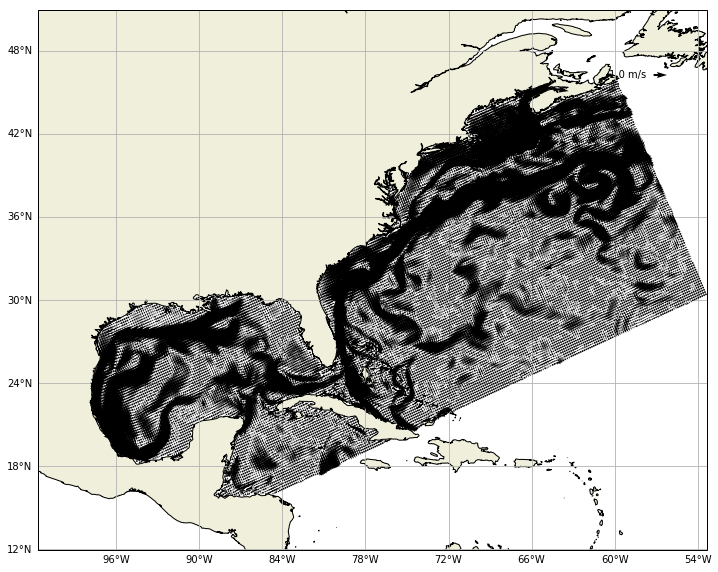

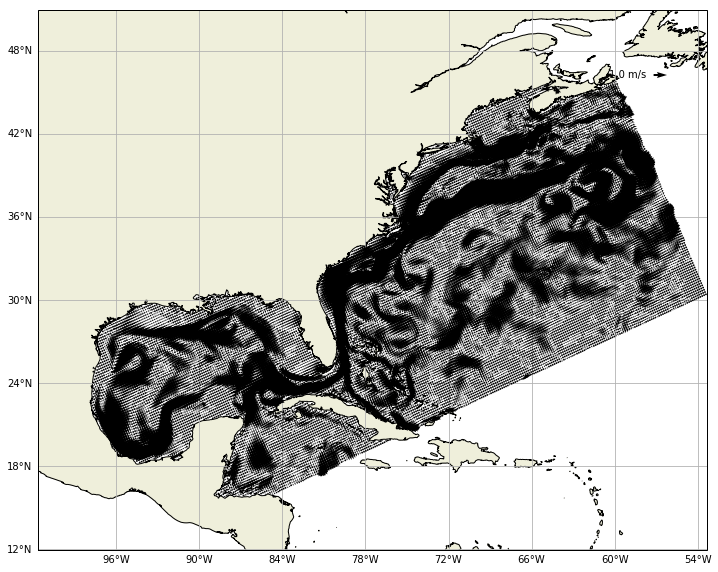

In [19]:
#mapdraw(tidx, lon_c, lat_c)
interact(mapdraw, tidx=(1,100,1))